In [6]:
!pip install eodhd

In [31]:
!pip install eod

                                              0.0/45.9 kB ? eta -:--:--
     ---------------------------------------- 45.9/45.9 kB 2.2 MB/s eta 0:00:00


In [128]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from datetime import datetime
from pathlib import Path
import requests
import nasdaqdatalink
import json
import tqdm
import time
import os
import tqdm
from eodhd import APIClient
import datetime
import matplotlib.pyplot as plt

In [13]:
api = "64d77f6d3a60a5.24835840" #API key

### Defining functions

In [120]:
def convert_json(response):
    """
    Converts a json format variable to a pandasdataframe and converts its datetime string to a datetime format.
    
    Args: Response from API call
    
    returns: pandas dataframe
    """
    df = pd.DataFrame(response.json()['values'])
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    return df

def stock_data(ticker):
    """
    Get stock data using twelvedata API connection. 
    
    Args(str): ticker name of the stock
    
    Returns a pandas dataframe outer-merged on 'datetime' 
    """
    
    ###MAKE API CLALL###
    Timeseries = requests.get(f'https://eodhistoricaldata.com/api/eod/{ticker}.US?order=d&from=2020-01-01&to=2023-07-31&period=d&&api_token={api}&fmt=json')
    #Momentum for one company - example: AAPL
    momentum = requests.get(f"https://api.twelvedata.com/mom?apikey=1166574b73ce408ca939ca15595f719e&interval=1day&symbol={ticker}&timezone=America/New_York&start_date=2020-01-01 00:00:00&end_date=2023-07-31 23:59:59&format=JSON&dp=2")
    #Relative strength index for one company
    rsi = requests.get(f"https://api.twelvedata.com/rsi?apikey=1166574b73ce408ca939ca15595f719e&interval=1day&symbol={ticker}&timezone=America/New_York&start_date=2020-01-01 00:00:00&end_date=2023-07-31 23:59:59&format=JSON&dp=2")
    #Money flow index - MFI 
    mfi = requests.get(f"https://api.twelvedata.com/mfi?apikey=1166574b73ce408ca939ca15595f719e&interval=1day&symbol={ticker}&timezone=America/New_York&start_date=2020-01-01 00:00:00&end_date=2023-07-31 23:59:59&format=JSON&dp=2")
    
    ### convert json files to pandas dataframes
    timeseries_df = pd.DataFrame(Timeseries.json()).rename(columns = {"date":"datetime"})
    timeseries_df["datetime"] = pd.to_datetime(timeseries_df["datetime"])
    momentum_df = convert_json(momentum)
    rsi_df = convert_json(rsi)
    mfi_df = convert_json(mfi)
    
    #Join dataframes on "datetime", how = "outer"
    stock_df = timeseries_df.merge(momentum_df, on = "datetime", how = "outer")
    stock_df = stock_df.merge(rsi_df, on = "datetime", how = "outer")
    stock_df = stock_df.merge(mfi_df, on = "datetime", how = "outer")
    
    return stock_df

def df_to_csv(df, name):
    """
    Save a pandas dataframe into a csv file
    
    Args(pd.DataFrame, str): dataframe and the name of the file it should return.
    When working with stock data name should be the ticker of the specified stock.
    
    requirements = requests, pandas, json should be installed and imported.
    
    returns 0, creates a csv file in /Data/Financial data
    """

    pathname = Path.cwd()/f"Eod/{name}.csv"
    
    df.to_csv(pathname, index = False)
    
    return None

def log(ticker, df, logfile, output_path=os.getcwd()):
    #open or create the csv file
    if os.path.isfile(logfile): #if log file exist, open and allow changes
        log = open(logfile,'a')
    else:
        log = open(logfile,'w')
        header = ['timestamp', 'Status', 'length', 'output_file']
        log.write(";".join(header)+"\n") #Make the headers and jump to the new line
    
    #Gather log information
    status_code = f"last call made happened in ticker {ticker}"
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) #local time
    length = len(df) #Lenght of HTML string
    
    #Open the log file and append the gathered log information
    with open(logfile, 'a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path}' + "\n") #Append the information and jump to the new line.

In [108]:
from eod import EodHistoricalData
client = EodHistoricalData(api)
financial_data = Path.cwd()

In [130]:
nasdaq = pd.read_csv("NASDAQ All companies.csv")
nasdaq = nasdaq.sort_values("Market Cap", ascending = False)
nasdaq = nasdaq[:200].reset_index()
tickers = nasdaq["Symbol"].values

### Get EoD stock prices

In [110]:
eod_folder = Path.cwd()/"Eod" #path to create folder where end of day stock prices will be stored
earnings_folder = Path.cwd()/"earnings"
Path.mkdir(eod_folder, exist_ok=True)
Path.mkdir(earnings_folder, exist_ok=True)

In [134]:
logfile = Path.cwd()/f'financial_data_logs.csv'
missing = []
index_missing = []

for i, ticker in tqdm.tqdm(enumerate(tickers)):
    try:
        df = stock_data(ticker) #save data of a single stock in dataframe
        df_to_csv(df,ticker) #save dataframe to csv in folder 'Eod'
        log(ticker, df, logfile)
    except:
        print(f'Company {ticker} was not retrieved')
        missing.append(ticker)
        index_missing.append(i)
        time.sleep(60)
    time.sleep(60)

5it [05:06, 61.26s/it]

Company NVDA was not retrieved


69it [7:55:41, 61.26s/it]  

Company FWONK was not retrieved


76it [8:03:52, 63.57s/it]

Company FWONA was not retrieved


165it [9:36:03, 62.36s/it]

Company LSXMB was not retrieved


172it [9:44:15, 64.25s/it]

Company LSXMK was not retrieved


176it [9:49:21, 68.45s/it]

Company LSXMA was not retrieved


200it [10:15:01, 184.51s/it]


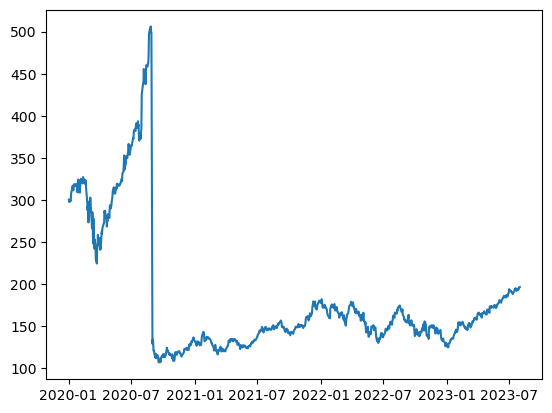

In [135]:
plt.plot(aapl["datetime"],aapl["close"])

In [136]:
missing

['NVDA', 'FWONK', 'FWONA', 'LSXMB', 'LSXMK', 'LSXMA']

### Technicals using eodhd
Apparently with no acces in our current plan

In [96]:
url = f'https://eodhistoricaldata.com/api/technical/{tickers[0]}.US?order=d&from=2020-01-01&to=2023-07-31&function=rsi&period=d&&api_token={api}&fmt=json'

### Get earnings

In [39]:
url = f"http://eodhistoricaldata.com/api/fundamentals/AAPL.US?api_token={api}&filter=General::Code,General,Earnings"
resp = requests.get(url)

In [60]:
earnings = pd.DataFrame(resp.json()["Earnings"]["History"]).T
earnings = earnings[earnings["beforeAfterMarket"]!="BeforeMarket"]
earnings

,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
2023-06-30,2023-08-03,2023-06-30,AfterMarket,USD,1.26,1.19,0.07,5.8824
2023-03-31,2023-05-04,2023-03-31,AfterMarket,USD,1.52,1.43,0.09,6.2937
2022-12-31,2023-02-02,2022-12-31,AfterMarket,USD,1.88,1.94,-0.06,-3.0928
2022-09-30,2022-10-27,2022-09-30,AfterMarket,USD,1.29,1.27,0.02,1.5748
2022-06-30,2022-07-28,2022-06-30,AfterMarket,USD,1.2,1.16,0.04,3.4483
...,...,...,...,...,...,...,...,...
1994-12-31,1995-01-19,1994-12-31,None,USD,0.05,0.04,0.01,25
1994-09-30,1994-10-17,1994-09-30,None,USD,0.03,0.03,0,0
1994-06-30,1994-06-30,1994-06-30,None,USD,0.0104,None,None,None
1994-03-31,1994-03-31,1994-03-31,None,USD,0.0104,None,None,None


In [61]:
url = f"https://eodhistoricaldata.com/api/fundamentals/AAPL.US?api_token={api}"
resp = requests.get(url)